In [1]:
# %load C:\Workspace\University\DS_Workshop\DataManager.py
import pandas as pd
import numpy as np
import os
import os.path
from sklearn.preprocessing import LabelEncoder

class MultiColumnLabelEncoder(LabelEncoder):
    """
    Wraps sklearn LabelEncoder functionality for use on multiple columns of a
    pandas dataframe.

    """
    def __init__(self, columns=None):
        self.columns = np.asarray(columns)

    def fit(self, dframe):
        """
        Fit label encoder to pandas columns.

        Access individual column classes via indexig `self.all_classes_`

        Access individual column encoders via indexing
        `self.all_encoders_`
        """
        # if columns are provided, iterate through and get `classes_`
        if self.columns is not None:
            # ndarray to hold LabelEncoder().classes_ for each
            # column; should match the shape of specified `columns`
            self.all_classes_ = np.ndarray(shape=self.columns.shape,
                                           dtype=object)
            self.all_encoders_ = np.ndarray(shape=self.columns.shape,
                                            dtype=object)
            for idx, column in enumerate(self.columns):
                # fit LabelEncoder to get `classes_` for the column
                le = LabelEncoder()
                le.fit(dframe.loc[:, column].values)
                # append the `classes_` to our ndarray container
                self.all_classes_[idx] = (column,
                                          np.array(le.classes_.tolist(),
                                                  dtype=object))
                # append this column's encoder
                self.all_encoders_[idx] = le
        else:
            # no columns specified; assume all are to be encoded
            self.columns = dframe.iloc[:, :].columns
            self.all_classes_ = np.ndarray(shape=self.columns.shape,
                                           dtype=object)
            for idx, column in enumerate(self.columns):
                le = LabelEncoder()
                le.fit(dframe.loc[:, column].values)
                self.all_classes_[idx] = (column,
                                          np.array(le.classes_.tolist(),
                                                  dtype=object))
                self.all_encoders_[idx] = le
        return self

    def fit_transform(self, dframe):
        """
        Fit label encoder and return encoded labels.

        Access individual column classes via indexing
        `self.all_classes_`

        Access individual column encoders via indexing
        `self.all_encoders_`

        Access individual column encoded labels via indexing
        `self.all_labels_`
        """
        # if columns are provided, iterate through and get `classes_`
        if self.columns is not None:
            # ndarray to hold LabelEncoder().classes_ for each
            # column; should match the shape of specified `columns`
            self.all_classes_ = np.ndarray(shape=self.columns.shape,
                                           dtype=object)
            self.all_encoders_ = np.ndarray(shape=self.columns.shape,
                                            dtype=object)
            self.all_labels_ = np.ndarray(shape=self.columns.shape,
                                          dtype=object)
            for idx, column in enumerate(self.columns):
                # instantiate LabelEncoder
                le = LabelEncoder()
                # fit and transform labels in the column
                dframe.loc[:, column] =\
                    le.fit_transform(dframe.loc[:, column].values)
                # append the `classes_` to our ndarray container
                self.all_classes_[idx] = (column,
                                          np.array(le.classes_.tolist(),
                                                  dtype=object))
                self.all_encoders_[idx] = le
                self.all_labels_[idx] = le
        else:
            # no columns specified; assume all are to be encoded
            self.columns = dframe.iloc[:, :].columns
            self.all_classes_ = np.ndarray(shape=self.columns.shape,
                                           dtype=object)
            for idx, column in enumerate(self.columns):
                le = LabelEncoder()
                dframe.loc[:, column] = le.fit_transform(
                        dframe.loc[:, column].values)
                self.all_classes_[idx] = (column,
                                          np.array(le.classes_.tolist(),
                                                  dtype=object))
                self.all_encoders_[idx] = le
        return dframe

    def transform(self, dframe):
        """
        Transform labels to normalized encoding.
        """
        if self.columns is not None:
            for idx, column in enumerate(self.columns):
                dframe.loc[:, column] = self.all_encoders_[
                    idx].transform(dframe.loc[:, column].values)
        else:
            self.columns = dframe.iloc[:, :].columns
            for idx, column in enumerate(self.columns):
                dframe.loc[:, column] = self.all_encoders_[idx]\
                    .transform(dframe.loc[:, column].values)
        return dframe.loc[:, self.columns].values

    def inverse_transform(self, dframe,specificColumn=None):
        """
        Transform labels back to original encoding.
        """    

        if self.columns is not None:
            
            for idx, column in enumerate(self.columns):
                if specificColumn is not None and column == specificColumn:
                    dframe.loc[:, specificColumn] = self.all_encoders_[idx]\
                            .inverse_transform(dframe.loc[:, specificColumn].values)
                    return dframe
                else:
                    dframe.loc[:, column] = self.all_encoders_[idx]\
                        .inverse_transform(dframe.loc[:, column].values)
        else:
            self.columns = dframe.iloc[:, :].columns
            for idx, column in enumerate(self.columns):
                dframe.loc[:, column] = self.all_encoders_[idx]\
                    .inverse_transform(dframe.loc[:, column].values)
        return dframe
    
class DataManager(object):
    
    '''
        Init

        Params:
            dir: Full path to the directory that holds each date folder (root directory)
    '''
    def __init__(self,dir):
        self.rootdir = dir
        self.fields = [];
        self.mcle = {}
       
    '''
    Return: training, test
            (as pandas dataframes)
    Params:
        df: pandas dataframe
        trainPerc: float | percentage of data for training set (default=0.8)
        testPerc: float | percentage of data for test set (default=0.2)
        isRandom: bool | shuffle the data before the split (default = True)
    '''
    def splitData(self,df, trainPerc=0.8, testPerc=0.2, isRandom=True):

        # create random list of indices
        from random import shuffle
        N = len(df)
        l = range(N)
        if(isRandom):
            shuffle(l)

        # get splitting indicies
        trainLen = int(N*trainPerc)

        # get training, and test sets
        train = df.iloc[l[:trainLen]]
        test     = df.iloc[l[trainLen:]]
        
        print("Train Size: " + str(len(train)) + " Test Size: " + str(len(test)))

        return train, test

    '''
        Load Data

        Return: Data object (all categorical fields are converted to integers)
            (as pandas dataframes)

        Params:
            fields (not required): Column names that we want to read
            transformFields (not required): Transforms the String fields into int
            onlyFirstFile (not required): Only loads the first file
            removeFirstK (not required): Removes the first users with highest number of Sids
    '''
    def loadData(self,fields=False,transformFields=True,onlyFirstFile=False,removeFirstK=0,isFirstMonth=False):

        self.fields = fields;
        if(not self.fields):
            self.fields = ["Browser","Device","Os","Resolution","Continent", "Country","Sid","Aid","Pn", "QueryName","Response","Result","Status","StatusText","Type"]
        
        ajax_events_list = []
        i=0
        for subdir, dirs, files in os.walk(self.rootdir):
            for dir in dirs:
                i+=1
                # Load the csv and append to a list
                print('reading the ajax file in {0}'.format(dir))
                ajax_events_list.append(pd.read_csv(os.path.join(self.rootdir,dir,'ajax_events.csv'),usecols=self.fields))
                if(onlyFirstFile):
                    break;     
                if(isFirstMonth and i>31):
                    break;     
        # Concat the list of the dataframes
        df = pd.concat(ajax_events_list)
                
        if(removeFirstK > 0 and 'Aid' in self.fields):            
            result = df.groupby('Aid').apply(
                 lambda group: (group.Sid.nunique())
             )

            result.sort_values(inplace=True,ascending=False)
        
            for selectedAid in result.keys()[0:removeFirstK]:
                print(str(selectedAid))    
                df = df.loc[df['Aid'] != selectedAid]

        #df = df.loc[df['QueryName'] != "RequestSummaryQuery"]

        if(transformFields):                                             
            # Transform all the string columns into integers
            self.mcle = MultiColumnLabelEncoder(columns=self.fields)
            
            # Returns a matrix of integers 
            res = self.mcle.fit_transform(df)
        else:
            res = df

        print("The data has been loaded")
       

        return res

    '''
        Searches for the label in the decoded dataset and then encodes back and returns the encoded value for the label 

        Ex: dataManager.getEncodedByLabel(data,"Aid","21674def-1c93-46e5-95ab-015e904fb10f")

        Params:
            data: The encoded data (transformFields=true in load data)
            field: The field that the label comes from
            value: The value we are looking for
    '''
    def getEncodedByLabel(self,data,field,value):

        idx = self.fields.index(field);
        # Decode the dataset to the regular dataset
        inversed = self.mcle.all_encoders_[idx].inverse_transform(data.loc[:, field].values);

        # Search for the label and get the encoded value
        ret = self.mcle.all_encoders_[idx].transform(inversed[inversed == value])[0];

        return ret;
    


In [2]:
liorDir = "D:\DataScienceWorkshop"

dataManager = DataManager(liorDir)

In [3]:
import warnings
warnings.filterwarnings('ignore', 'numpy not_equal will not check object identity in the future')
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
#from sklearn.cluster import AgglomerativeClustering as hc
from sklearn.metrics import silhouette_samples, silhouette_score
from time import clock
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from matplotlib import colors
from random import randint

In [4]:
data = dataManager.loadData(["TimeStamp","Pn","QueryName","Sid","Aid"],transformFields=False,removeFirstK=5,isFirstMonth=True)    


reading the ajax file in day_2015-10-01 - 2015-10-02
reading the ajax file in day_2015-10-02 - 2015-10-03
reading the ajax file in day_2015-10-03 - 2015-10-04
reading the ajax file in day_2015-10-04 - 2015-10-05
reading the ajax file in day_2015-10-05 - 2015-10-06
reading the ajax file in day_2015-10-06 - 2015-10-07
reading the ajax file in day_2015-10-07 - 2015-10-08
reading the ajax file in day_2015-10-08 - 2015-10-09
reading the ajax file in day_2015-10-09 - 2015-10-10
reading the ajax file in day_2015-10-10 - 2015-10-11
reading the ajax file in day_2015-10-11 - 2015-10-12
reading the ajax file in day_2015-10-12 - 2015-10-13
reading the ajax file in day_2015-10-13 - 2015-10-14
reading the ajax file in day_2015-10-14 - 2015-10-15
reading the ajax file in day_2015-10-15 - 2015-10-16
reading the ajax file in day_2015-10-16 - 2015-10-17
reading the ajax file in day_2015-10-17 - 2015-10-18
reading the ajax file in day_2015-10-18 - 2015-10-19
reading the ajax file in day_2015-10-19 - 2015

3208.0
39263.8865248


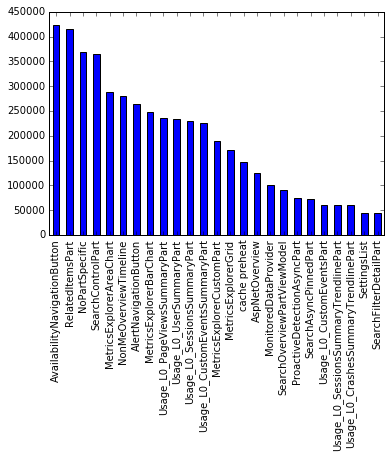

In [7]:
%matplotlib inline

col = "Pn"

value_counts = data[col].value_counts() # Specific column 
threshold = value_counts.mean()
print(value_counts.median())
print(threshold)
to_remove = value_counts[value_counts <= threshold].index
cleanedData = data[col].replace(to_remove, np.nan, inplace=False)
pd.value_counts(cleanedData).plot(kind="bar")
allDataAboveMean = data[data.Pn == cleanedData]

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jun 22 15:14:20 2015
@author: Balázs Hidasi
"""

import theano
from theano import tensor as T
from theano import function
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
import numpy as np
import pandas as pd
from collections import OrderedDict
import time
import math
srng = RandomStreams()
def timing(f):
    def wrap(*args):
        time1 = time.time()
        ret = f(*args)
        time2 = time.time()
        print '%s function took %0.3f ms' % (f.func_name, (time2-time1)*1000.0)
        return ret
    return wrap


class GRU4Rec:
    '''
    GRU4Rec(layers, n_epochs=10, batch_size=50, dropout_p_hidden=0.4, learning_rate=0.05, momentum=0.0, adapt='adagrad', decay=0.9, grad_cap=0, sigma=0, init_as_normal=False, reset_after_session=True, loss='top1', hidden_act='tanh', final_act=None, train_random_order=False, lmbd=0.0, session_key='SessionId', item_key='ItemId', time_key='Time')
    
    Initializes the network.

    Parameters
    -----------
    layers : 1D array
        list of the number of GRU units in the layers (default: [100] --> 100 units in one layer)
    n_epochs : int
        number of training epochs (default: 10)
    batch_size : int
        size of the minibacth, also effect the number of negative samples through minibatch based sampling (default: 50)
    dropout_p_hidden : float
        probability of dropout of hidden units (default: 0.4)
    learning_rate : float
        learning rate (default: 0.05)
    momentum : float
        if not zero, Nesterov momentum will be applied during training with the given strength (default: 0.0)
    adapt : None, 'adagrad' or 'rmsprop'
        sets the appropriate learning rate adaptation strategy (default: 'adagrad')
    decay : float
        decay parameter for RMSProp, has no effect in other modes (default: 0.9)
    grad_cap : float
        clip gradients that exceede this value to this value, 0 means no clipping (default: 0.0)
    sigma : float
        "width" of initialization; either the standard deviation or the min/max of the init interval (with normal and uniform initializations respectively); 0 means adaptive normalization (sigma depends on the size of the weight matrix); (default: 0)
    init_as_normal : boolean
        False: init from uniform distribution on [-sigma,sigma]; True: init from normal distribution N(0,sigma); (default: False)
    reset_after_session : boolean
        whether the hidden state is set to zero after a session finished (default: True)
    loss : 'top1', 'bpr' or 'cross-entropy'
        selects the loss function (default: 'top1')
    hidden_act : 'tanh' or 'relu' 
        selects the activation function on the hidden states (default: 'tanh')
    final_act : None, 'linear', 'relu' or 'tanh' 
        selects the activation function of the final layer where appropriate (cross-entropy always uses softmax), None means default (tanh if the loss is brp or top1) (default: None)
    train_random_order : boolean
        whether to randomize the order of sessions in each epoch (default: False)
    lmbd : float
        coefficient of the L2 regularization (default: 0.0)
    session_key : string
        header of the session ID column in the input file (default: 'SessionId')
    item_key : string
        header of the item ID column in the input file (default: 'ItemId')
    time_key : string
        header of the timestamp column in the input file (default: 'Time')
        
    '''
    def __init__(self, layers, n_epochs=10, batch_size=50, dropout_p_hidden=0.4, learning_rate=0.05, momentum=0.0, adapt='adagrad', decay=0.9, grad_cap=0, sigma=0, 
                 init_as_normal=False, reset_after_session=True, loss='top1', hidden_act='tanh', final_act=None, train_random_order=False, lmbd=0.0, 
                 session_key='SessionId', item_key='ItemId', time_key='Time'):
        self.layers = layers
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.dropout_p_hidden = dropout_p_hidden
        self.learning_rate = learning_rate
        self.decay = decay
        self.momentum = momentum
        self.sigma = sigma
        self.init_as_normal = init_as_normal
        self.reset_after_session = reset_after_session
        self.session_key = session_key
        self.item_key = item_key
        self.time_key = time_key
        self.grad_cap = grad_cap
        self.train_random_order = train_random_order
        self.lmbd = lmbd
        if adapt == 'rmsprop':
            self.adapt = 'rmsprop'
        elif adapt == 'adagrad':
            self.adapt = 'adagrad'
        else:
            self.adapt = False
        if loss=='cross-entropy':
            self.final_activation=self.softmax
            self.loss_function=self.cross_entropy
        elif loss=='bpr':
            if final_act == 'linear':
                self.final_activation = self.linear
            elif final_act == 'relu':
                self.final_activation = self.relu
            else:
                self.final_activation=self.tanh
            self.loss_function=self.bpr
        elif loss=='top1':
            if final_act == 'linear':
                self.final_activation = self.linear
            elif final_act == 'relu':
                self.final_activation = self.relu
            else:
                self.final_activation=self.tanh
            self.loss_function=self.top1
        else:
            raise NotImplementedError
        if hidden_act=='relu':
            self.hidden_activation=self.relu
        elif hidden_act=='tanh':
            self.hidden_activation=self.tanh
        else:
            raise NotImplementedError
    ######################ACTIVATION FUNCTIONS FOR FINAL LAYER#####################
    def linear(self,X):
        return X
    def tanh(self,X):
        return T.tanh(X)
    def softmax(self,X):
        e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 'x'))
        return e_x / e_x.sum(axis=1).dimshuffle(0, 'x')
    def relu(self,X):
        return T.maximum(X, 0)
    def sigmoid(self, X):
        return T.nnet.sigmoid(X)
    #################################LOSS FUNCTIONS################################
    #It is assumed that only one desired output is active (otherwise it will be very slow)
    #Use softmax activation function as the output with cross-entropy
    def cross_entropy(self, yhat):
        return T.cast(T.mean(-T.log(T.diag(yhat))), theano.config.floatX)
    #It is assumed that only one desired output is active (otherwise it will be very slow)
    #Use linear or tanh activation function as the output with BPR
    def bpr(self, yhat):
        return T.cast(T.mean(-T.log(T.nnet.sigmoid(T.diag(yhat)-yhat.T))), theano.config.floatX)
    #It is assumed that only one desired output is active (otherwise it will be very slow)
    #Use linear or tanh activation function as the output with error-rate
    def top1(self, yhat):
        return T.cast(T.mean(T.mean(T.nnet.sigmoid(-T.diag(yhat)+yhat.T)+T.nnet.sigmoid(yhat.T**2), axis=0)-T.nnet.sigmoid(T.diag(yhat)**2)/self.batch_size), theano.config.floatX)
    
    ###############################################################################
    def floatX(self, X):
        return np.asarray(X, dtype=theano.config.floatX)
    def init_weights(self, shape):
        sigma = self.sigma if self.sigma != 0 else np.sqrt(6.0 / (shape[0] + shape[1]))
        if self.init_as_normal:
            return theano.shared(self.floatX(np.random.randn(*shape) * sigma), borrow=True)
        else:
            return theano.shared(self.floatX(np.random.rand(*shape) * sigma * 2 - sigma), borrow=True)
    def init(self, data):
        data.sort_values([self.session_key, self.time_key], inplace=True)
        # Create a vector in the size of the unique sessions
        offset_sessions = np.zeros(data[self.session_key].nunique()+1, dtype=np.int32)
        # For each session get the number of requests in it and then sum it cummulutive (ex: session 1 has 10 queries, and session 2 has 6, then we get an array of (10,16))
        offset_sessions[1:] = data.groupby(self.session_key).size().cumsum()
        np.random.seed(42)
        self.Wx, self.Wh, self.Wr, self.Wz, self.Whr, self.Whz, self.Bh, self.Br, self.Bz, self.H = [], [], [], [], [], [], [], [], [], []
        for i in range(len(self.layers)):
            self.Wx.append(self.init_weights((self.layers[i-1] if i > 0 else self.n_items, self.layers[i])))
            self.Wr.append(self.init_weights((self.layers[i-1] if i > 0 else self.n_items, self.layers[i])))
            self.Wz.append(self.init_weights((self.layers[i-1] if i > 0 else self.n_items, self.layers[i])))
            self.Wh.append(self.init_weights((self.layers[i], self.layers[i])))
            self.Whr.append(self.init_weights((self.layers[i], self.layers[i])))
            self.Whz.append(self.init_weights((self.layers[i], self.layers[i])))
            self.Bh.append(theano.shared(value=np.zeros((self.layers[i],), dtype=theano.config.floatX), borrow=True))
            self.Br.append(theano.shared(value=np.zeros((self.layers[i],), dtype=theano.config.floatX), borrow=True))
            self.Bz.append(theano.shared(value=np.zeros((self.layers[i],), dtype=theano.config.floatX), borrow=True))
            self.H.append(theano.shared(value=np.zeros((self.batch_size,self.layers[i]), dtype=theano.config.floatX), borrow=True))
        self.Wy = self.init_weights((self.n_items, self.layers[-1]))
        self.By = theano.shared(value=np.zeros((self.n_items,1), dtype=theano.config.floatX), borrow=True)
        return offset_sessions
    def dropout(self, X, drop_p):
        if drop_p > 0:
            retain_prob = 1 - drop_p
            X *= srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX) / retain_prob
        return X
    def RMSprop(self, cost, params, full_params, sampled_params, sidxs, epsilon=1e-6):
        v1 = np.float32(self.decay if self.adapt == 'rmsprop' else 1)
        v2 = np.float32((1.0 - self.decay) if self.adapt == 'rmsprop' else 1)
        grads =  [T.grad(cost = cost, wrt = param) for param in params]
        sgrads = [T.grad(cost = cost, wrt = sparam) for sparam in sampled_params]
        updates = OrderedDict()
        if self.grad_cap>0:
            norm=T.cast(T.sqrt(T.sum([T.sum([T.sum(g**2) for g in g_list]) for g_list in grads]) + T.sum([T.sum(g**2) for g in sgrads])), theano.config.floatX)
            grads = [[T.switch(T.ge(norm, self.grad_cap), g*self.grad_cap/norm, g) for g in g_list] for g_list in grads]
            sgrads = [T.switch(T.ge(norm, self.grad_cap), g*self.grad_cap/norm, g) for g in sgrads]
        for p_list, g_list in zip(params, grads):
            for p, g in zip(p_list, g_list):
                if self.adapt:
                    acc = theano.shared(p.get_value(borrow=False) * 0., borrow=True)
                    acc_new = v1 * acc + v2 * g ** 2
                    gradient_scaling = T.cast(T.sqrt(acc_new + epsilon), theano.config.floatX)
                    g = g / gradient_scaling
                    updates[acc] = acc_new
                if self.momentum > 0:
                    velocity = theano.shared(p.get_value(borrow=False) * 0., borrow=True)
                    velocity2 = self.momentum * velocity - np.float32(self.learning_rate) * (g + self.lmbd * p)
                    updates[velocity] = velocity2
                    updates[p] = p + velocity2
                else:
                    updates[p] = p * np.float32(1.0 - self.learning_rate * self.lmbd) - np.float32(self.learning_rate) * g
        for i in range(len(sgrads)):
            g = sgrads[i]
            fullP = full_params[i]
            sample_idx = sidxs[i]
            sparam = sampled_params[i]
            if self.adapt:
                acc = theano.shared(fullP.get_value(borrow=False) * 0., borrow=True)
                acc_s = acc[sample_idx]
                acc_new = v1 * acc_s + v2 * g ** 2
                gradient_scaling = T.cast(T.sqrt(acc_new + epsilon), theano.config.floatX)
                g = g / gradient_scaling
                updates[acc] = T.set_subtensor(acc_s, acc_new)
            if self.lmbd > 0:
                delta = np.float32(self.learning_rate) * (g + self.lmbd * sparam)
            else:
                delta = np.float32(self.learning_rate) * g
            if self.momentum > 0:
                velocity = theano.shared(fullP.get_value(borrow=False) * 0., borrow=True)
                vs = velocity[sample_idx]
                velocity2 = self.momentum * vs - delta
                updates[velocity] = T.set_subtensor(vs, velocity2)
                updates[fullP] = T.inc_subtensor(sparam, velocity2)
            else:
                updates[fullP] = T.inc_subtensor(sparam, - delta)
        return updates
    def model(self, X, H, Y, drop_p_hidden):
        Sx = self.Wx[0][X]
        Sr = self.Wr[0][X]
        Sz = self.Wz[0][X]
        r = T.nnet.sigmoid(Sr + T.dot(H[0], self.Whr[0]) + self.Br[0])

        h = self.hidden_activation(Sx + T.dot(H[0] * r, self.Wh[0]) + self.Bh[0])

        z = T.nnet.sigmoid(Sz + T.dot(H[0], self.Whz[0]) + self.Bz[0])
        h = (1.0-z)*H[0] + z*h
        h = self.dropout(h, drop_p_hidden)
        H_new = [h]
        y = h
        for i in range(1, len(self.layers)):
            r = T.nnet.sigmoid(T.dot(y, self.Wr[i]) + T.dot(H[i], self.Whr[i]) + self.Br[i])
            h = self.hidden_activation(T.dot(y, self.Wx[i]) + T.dot(H[i]*r, self.Wh[i]) + self.Bh[i])
            z = T.nnet.sigmoid(T.dot(y, self.Wz[i]) + T.dot(H[i], self.Whz[i]) + self.Bz[i])
            h = (1.0-z)*H[i] + z*h
            h = self.dropout(h, drop_p_hidden)
            H_new.append(h)
            y = h
        Sy = self.Wy[Y]
        SBy = self.By[Y]
        y = self.final_activation(T.dot(y, Sy.T) + SBy.flatten())
        return H_new, y, [Sx, Sr, Sz, Sy, SBy]
    def model_test(self, X, H):
        Sx = self.Wx[0][X]
        Sr = self.Wr[0][X]
        Sz = self.Wz[0][X]
        r = T.nnet.sigmoid(Sr + T.dot(H[0], self.Whr[0]) + self.Br[0])
        h = self.hidden_activation(Sx + T.dot(H[0] * r, self.Wh[0]) + self.Bh[0])
        z = T.nnet.sigmoid(Sz + T.dot(H[0], self.Whz[0]) + self.Bz[0])
        h = (1.0-z)*H[0] + z*h
        H_new = [h]
        y = h
        for i in range(1, len(self.layers)):
            r = T.nnet.sigmoid(T.dot(y, self.Wr[i]) + T.dot(H[i], self.Whr[i]) + self.Br[i])
            h = self.hidden_activation(T.dot(y, self.Wx[i]) + T.dot(H[i]*r, self.Wh[i]) + self.Bh[i])
            z = T.nnet.sigmoid(T.dot(y, self.Wz[i]) + T.dot(H[i], self.Whz[i]) + self.Bz[i])
            h = (1.0-z)*H[i] + z*h
            H_new.append(h)
            y = h
        y = self.final_activation(T.dot(y, self.Wy.T) + self.By.flatten())
        return H_new, y
    
    def setItemMap(self,data):        
        self.itemids = data[self.item_key].unique()
        self.n_items = len(self.itemids)
        self.itemidmap = pd.Series(data=np.arange(self.n_items), index=self.itemids)
    
    @timing
    def fit(self, data):
        ''' 
        Trains the network.
        
        Parameters
        --------
        data: pandas.DataFrame
            Training data. It contains the transactions of the sessions. It has one column for session IDs, one for item IDs and one for the timestamp of the events (unix timestamps).
            It must have a header. Column names are arbitrary, but must correspond to the ones you set during the initialization of the network (session_key, item_key, time_key properties).
            
        '''
        self.predict = None
        self.error_during_train = False
        #itemids = data[self.item_key].unique()
        #self.n_items = len(itemids)
        #self.itemidmap = pd.Series(data=np.arange(self.n_items), index=itemids)
        # Add ItemIdx column to the dataframe, remaps the query name id into item id
        data = pd.merge(data, pd.DataFrame({self.item_key:self.itemids, 'ItemIdx':self.itemidmap[self.itemids].values}), on=self.item_key, how='inner')
        offset_sessions = self.init(data)
        
        X = T.ivector()
        Y = T.ivector()
        H_new, Y_pred, sampled_params = self.model(X, self.H, Y, self.dropout_p_hidden)
        cost = self.loss_function(Y_pred) 
        params = [self.Wx[1:], self.Wr[1:], self.Wz[1:], self.Wh, self.Whr, self.Whz, self.Bh, self.Br, self.Bz]
        full_params = [self.Wx[0], self.Wr[0], self.Wz[0], self.Wy, self.By]
        sidxs = [X, X, X, Y, Y]
        updates = self.RMSprop(cost, params, full_params, sampled_params, sidxs)  
        for i in range(len(self.H)):
            updates[self.H[i]] = H_new[i]
        train_function = function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
        
        for epoch in range(self.n_epochs):
            for i in range(len(self.layers)):
                self.H[i].set_value(np.zeros((self.batch_size,self.layers[i]), dtype=theano.config.floatX), borrow=True)
            c = []
            session_idx_arr = np.random.permutation(len(offset_sessions)-1) if self.train_random_order else np.arange(len(offset_sessions)-1)
            iters = np.arange(self.batch_size)
            maxiter = iters.max()
            start = offset_sessions[session_idx_arr[iters]]
            end = offset_sessions[session_idx_arr[iters]+1]
            finished = False
            while not finished:
                minlen = (end-start).min() # minimum of the session size
                out_idx = data.ItemIdx.values[start] # Gets the first item for each session (if batch_size = 5 then it gets the first item of the first 5 sessions)
                for i in range(minlen-1):
                    in_idx = out_idx # Goes through the minimum session size and then trains the rnn by the values of the session
                    out_idx = data.ItemIdx.values[start+i+1] # The next items for the sessions
                    y = out_idx
                    cost = train_function(in_idx, y) 
                    c.append(cost)
                    if np.isnan(cost):
                        print(str(epoch) + ': NaN error!')
                        self.error_during_train = True
                        return
                start = start+minlen-1
                mask = np.arange(len(iters))[(end-start)<=1]
                for idx in mask:
                    maxiter += 1
                    if maxiter >= len(offset_sessions)-1:
                        finished = True
                        break
                    if self.reset_after_session:
                        for i in range(len(self.H)):
                            tmp = self.H[i].get_value(borrow=True, return_internal_type=True)
                            tmp[idx,:] = 0
                            self.H[i].set_value(tmp, borrow=True)
                    iters[idx] = maxiter
                    start[idx] = offset_sessions[session_idx_arr[maxiter]]
                    end[idx] = offset_sessions[session_idx_arr[maxiter]+1]
            avgc = np.mean(c)
            if np.isnan(avgc):
                print('Epoch {}: NaN error!'.format(str(epoch)))
                self.error_during_train = True
                return
            print('Epoch{}\tloss: {:.6f}'.format(epoch, avgc))

    def predict_next_batch(self, session_ids, input_item_ids, predict_for_item_ids=None, batch=100):
        '''
        Gives predicton scores for a selected set of items. Can be used in batch mode to predict for multiple independent events (i.e. events of different sessions) at once and thus speed up evaluation.
        
        If the session ID at a given coordinate of the session_ids parameter remains the same during subsequent calls of the function, the corresponding hidden state of the network will be kept intact (i.e. that's how one can predict an item to a session).
        If it changes, the hidden state of the network is reset to zeros.
                
        Parameters
        --------
        session_ids : 1D array
            Contains the session IDs of the events of the batch. Its length must equal to the prediction batch size (batch param).
        input_item_ids : 1D array
            Contains the item IDs of the events of the batch. Every item ID must be must be in the training data of the network. Its length must equal to the prediction batch size (batch param).
        predict_for_item_ids : 1D array (optional)
            IDs of items for which the network should give prediction scores. Every ID must be in the training set. The default value is None, which means that the network gives prediction on its every output (i.e. for all items in the training set).
        batch : int
            Prediction batch size.
            
        Returns
        --------
        out : pandas.DataFrame
            Prediction scores for selected items for every event of the batch. 
            Columns: events of the batch; rows: items. Rows are indexed by the item IDs.
        
        '''
        if self.error_during_train: raise Exception
        if self.predict is None or self.predict_batch!=batch:
            X = T.ivector()
            Y = T.ivector()
            for i in range(len(self.layers)):
                self.H[i].set_value(np.zeros((batch,self.layers[i]), dtype=theano.config.floatX), borrow=True)
            if predict_for_item_ids is not None:
                H_new, yhat, _ = self.model(X, self.H, Y, 0)
            else:
                H_new, yhat = self.model_test(X, self.H)
            updatesH = OrderedDict()
            for i in range(len(self.H)):
                updatesH[self.H[i]] = H_new[i]
            if predict_for_item_ids is not None:
                self.predict = function(inputs=[X, Y], outputs=yhat, updates=updatesH, allow_input_downcast=True)
            else:
                self.predict = function(inputs=[X], outputs=yhat, updates=updatesH, allow_input_downcast=True)
            self.current_session = np.ones(batch) * -1
            self.predict_batch = batch
        session_change = np.arange(batch)[session_ids != self.current_session]
        if len(session_change) > 0:
            for i in range(len(self.H)):
                tmp = self.H[i].get_value(borrow=True)
                tmp[session_change] = 0
                self.H[i].set_value(tmp, borrow=True)
            self.current_session=session_ids.copy()
        in_idxs = self.itemidmap[input_item_ids]
        if predict_for_item_ids is not None:
            iIdxs = self.itemidmap[predict_for_item_ids]
            preds = np.asarray(self.predict(in_idxs, iIdxs)).T
            return pd.DataFrame(data=preds, index=predict_for_item_ids)
        else:
            in_idxs.values[np.isnan(in_idxs.values)] = 0 
            preds = np.asarray(self.predict(in_idxs)).T
            return pd.DataFrame(data=preds, index=self.itemidmap.index)
    
    def evaluate_sessions_batch(self, test_data, items=None, cut_off=20, batch_size=100, break_ties=False, session_key='SessionId', item_key='ItemId', time_key='Time',display=False):
        '''
        Evaluates the GRU4Rec network wrt. recommendation accuracy measured by recall@N and MRR@N.

        Parameters
        --------
        self : gru4rec.GRU4Rec
            A trained instance of the GRU4Rec network.
        test_data : pandas.DataFrame
            Test data. It contains the transactions of the test set.It has one column for session IDs, one for item IDs and one for the timestamp of the events (unix timestamps).
            It must have a header. Column names are arbitrary, but must correspond to the keys you use in this function.
        items : 1D list or None
            The list of item ID that you want to compare the score of the relevant item to. If None, all items of the training set are used. Default value is None.
        cut-off : int
            Cut-off value (i.e. the length of the recommendation list; N for recall@N and MRR@N). Defauld value is 20.
        batch_size : int
            Number of events bundled into a batch during evaluation. Speeds up evaluation. If it is set high, the memory consumption increases. Default value is 100.
        break_ties : boolean
            Whether to add a small random number to each prediction value in order to break up possible ties, which can mess up the evaluation. 
            Defaults to False, because (1) GRU4Rec usually does not produce ties, except when the output saturates; (2) it slows down the evaluation.
            Set to True is you expect lots of ties.
        session_key : string
            Header of the session ID column in the input file (default: 'SessionId')
        item_key : string
            Header of the item ID column in the input file (default: 'ItemId')
        time_key : string
            Header of the timestamp column in the input file (default: 'Time')
    
        Returns
        --------
        out : tuple
            (Recall@N, MRR@N)
    
        '''
        self.predict = None #In case someone would try to run with both items=None and not None on the same model without realizing that the predict function needs to be replaced
        test_data.is_copy = False
        test_data.sort_values([session_key, time_key], inplace=True) # Sort by session_key first and then by time_key
        offset_sessions = np.zeros(test_data[session_key].nunique()+1, dtype=np.int32) # Create an array of size of unique sessions
        offset_sessions[1:] = test_data.groupby(session_key).size().cumsum() # Fill the array with cumulative sum of items per session
        evalutation_point_count = 0
        mrr, recall = 0.0, 0.0
        if len(offset_sessions) - 1 < batch_size:
            batch_size = len(offset_sessions) - 1
        iters = np.arange(batch_size).astype(np.int32)
        maxiter = iters.max()
        start = offset_sessions[iters] # Start of the batch, subarray of cumulative sum in size of 1:batch_size 
        end = offset_sessions[iters+1] # Like start but starts one after and ends one afters
        in_idx = np.zeros(batch_size, dtype=np.int32)
        np.random.seed(42)
        while True:
            valid_mask = iters >= 0 # Converts iters array to array of booleans
            if valid_mask.sum() == 0:
                break
            start_valid = start[valid_mask]
            minlen = (end[valid_mask]-start_valid).min()
            #in_idx[valid_mask] = test_data[item_key].values[start_valid] - old
            # Getting the first of each session (batch)
            in_idx[valid_mask] = [self.itemidmap[itemName] for itemName in test_data[item_key].values[start_valid]] # Getting the id from the name 
            if(minlen > 1 and display):
                print("Session Length: "+str(minlen))

            for i in range(minlen-1):
                #out_idx = test_data[item_key].values[start_valid+i+1]
                if(display):
                    for itemName in test_data[item_key].values[start_valid+i+1]:
                        print(" -- " + itemName)
                    
                out_idx = [self.itemidmap[itemName] for itemName in test_data[item_key].values[start_valid+i+1]] 
                if items is not None:
                    uniq_out = np.unique(np.array(out_idx, dtype=np.int32))
                    preds = self.predict_next_batch(iters, in_idx, np.hstack([items, uniq_out[~np.in1d(uniq_out,items)]]), batch_size)
                else:
                    preds = self.predict_next_batch(iters, in_idx, None, batch_size)
                    # preds is a matrix of (rows= unique queries, columns = sessions in batch)
                    # Values = probability of the query as the next method
                if break_ties:
                    preds += np.random.rand(*preds.values.shape) * 1e-8
                preds.fillna(0, inplace=True)
                in_idx[valid_mask] = out_idx # Extending the input for each session (the session is getting bigger so we have a bigger history)
                if items is not None: # The list of item ID that you want to compare the score of the relevant item to. If None, all items of the training set are used
                    others = preds.ix[items].values.T[valid_mask].T
                    targets = np.diag(preds.ix[in_idx].values)[valid_mask]
                    ranks = (others > targets).sum(axis=0) +1
                else:
                    # ranks.shape = batch_size
                    # sums for each session the number of times that the prediction score was greater then the score that was given to the test's items
                    # so if there was no item with score higher the test item then the sum would be 0 (+1) = 1 which means the best
                    ranks = (preds.values.T[valid_mask].T > np.diag(preds.ix[in_idx].values)[valid_mask]).sum(axis=0) + 1
                rank_ok = ranks < cut_off
                if(display):
                    print(" -- " + str(rank_ok))
                recall += rank_ok.sum()
                mrr += (1.0 / ranks[rank_ok]).sum()
                evalutation_point_count += len(ranks)

            start = start+minlen-1
            mask = np.arange(len(iters))[(valid_mask) & (end-start<=1)]
            for idx in mask:
                maxiter += 1
                if maxiter >= len(offset_sessions)-1:
                    iters[idx] = -1
                else:
                    iters[idx] = maxiter
                    start[idx] = offset_sessions[maxiter]
                    end[idx] = offset_sessions[maxiter+1]
        return recall/evalutation_point_count, mrr/evalutation_point_count
   

In [6]:
session_key = "Sid" #"Aid" # Or Sid
time_key = "TimeStamp"
item_key = "Pn" #"QueryName"

train, test = dataManager.splitData(data,isRandom=False)



Train Size: 2468212 Test Size: 617054


In [7]:
session_key = "Sid" #"Aid" # Or Sid
item_key = "Pn" #"QueryName"
time_key = "TimeStamp"
batch_size = 500
for session_key in ['Sid','Aid']:
    for loss_type in ['top1','bpr']:
        for momentum in [2,3,4,5]:
            for dropOut in [2,3,4,5]:
                layers = 1000 
                print('Session Key: ' + session_key + ' Layers: ' + str(layers) + ' Batch Size: ' + str(batch_size) + ' Dropout: ' + str(float(dropOut)/10.0) + ' Momentum: ' + str(float(momentum)/10.0))
                gru = GRU4Rec(layers=[layers], loss=loss_type, batch_size=batch_size, dropout_p_hidden=float(dropOut)/10.0, learning_rate=0.05, momentum=float(momentum)/10.0
                                        ,n_epochs=3,hidden_act = 'tanh', final_act='tanh'
                                        ,session_key=session_key, item_key=item_key, time_key=time_key)
                gru.setItemMap(data.dropna())
                gru.fit(train.dropna())

                res = gru.evaluate_sessions_batch(test.dropna(), cut_off=2, batch_size=500, # Batch size = 1 inorder to better view each session
                                            session_key=session_key, item_key=item_key, time_key=time_key,display=False)

                print('Precision : {}'.format(res[0]))

Session Key: Sid Layers: 1000 Batch Size: 500 Dropout: 0.2 Momentum: 0.2
Epoch0	loss: 0.876094
Epoch1	loss: 0.873305
Epoch2	loss: 0.872023
fit function took 1249564.000 ms
Precision : 0.412278926351
Session Key: Sid Layers: 1000 Batch Size: 500 Dropout: 0.3 Momentum: 0.2
Epoch0	loss: 0.877612
Epoch1	loss: 0.874776
Epoch2	loss: 0.873469
fit function took 1282400.000 ms
Precision : 0.408495000818
Session Key: Sid Layers: 1000 Batch Size: 500 Dropout: 0.4 Momentum: 0.2
Epoch0	loss: 0.879471
Epoch1	loss: 0.876232
Epoch2	loss: 0.874894
fit function took 1280128.000 ms
Precision : 0.405469620358
Session Key: Sid Layers: 1000 Batch Size: 500 Dropout: 0.5 Momentum: 0.2
Epoch0	loss: 0.881840
Epoch1	loss: 0.877696
Epoch2	loss: 0.876186
fit function took 1282238.000 ms
Precision : 0.404438280655
Session Key: Sid Layers: 1000 Batch Size: 500 Dropout: 0.2 Momentum: 0.3
Epoch0	loss: 0.877631
Epoch1	loss: 0.874163
Epoch2	loss: 0.872732
fit function took 1284277.000 ms
Precision : 0.418694000102
Sessi

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/lshki/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-2.7.11-64/tmpyl6x8h/d6dbd929632140bafc5ccc42bafff8f7.lib and object C:/Users/lshki/AppData/Local/Theano/compiledir_Windows-10-10.0.10586-Intel64_Family_6_Model_94_Stepping_3_GenuineIntel-2.7.11-64/tmpyl6x8h/d6dbd929632140bafc5ccc42bafff8f7.exp



Epoch0	loss: 0.355752
Epoch1	loss: 0.347322
Epoch2	loss: 0.346104
fit function took 1277705.000 ms
Precision : 0.436858602623
Session Key: Sid Layers: 1000 Batch Size: 500 Dropout: 0.3 Momentum: 0.2
Epoch0	loss: 0.364715
Epoch1	loss: 0.364712
Epoch2	loss: 0.368000
fit function took 1235064.000 ms
Precision : 0.677070995243
Session Key: Sid Layers: 1000 Batch Size: 500 Dropout: 0.4 Momentum: 0.2
Epoch0	loss: 0.406883
Epoch1	loss: 0.407651
Epoch2	loss: 0.401549
fit function took 1235766.000 ms
Precision : 0.774154204645
Session Key: Sid Layers: 1000 Batch Size: 500 Dropout: 0.5 Momentum: 0.2
Epoch0	loss: 0.571171
Epoch1	loss: 0.502720
Epoch2	loss: 0.463786
fit function took 1261552.000 ms
Precision : 0.805942699048
Session Key: Sid Layers: 1000 Batch Size: 500 Dropout: 0.2 Momentum: 0.3
Epoch0	loss: 0.380470
Epoch1	loss: 0.400008
Epoch2	loss: 0.397430
fit function took 1260302.000 ms
Precision : 0.794062932841
Session Key: Sid Layers: 1000 Batch Size: 500 Dropout: 0.3 Momentum: 0.3
Epoch

RuntimeError: Cuda error: unknown error when trying to get the error value.\n
Apply node that caused the error: GpuAdvancedSubtensor1(<CudaNdarrayType(float32, matrix)>, Elemwise{Cast{int64}}.0)
Toposort index: 30
Inputs types: [CudaNdarrayType(float32, matrix), TensorType(int64, vector)]
Inputs shapes: [(122, 1000), (500L,)]
Inputs strides: [(1000, 1), (8L,)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[GpuElemwise{Composite{((i0 * i1) - (i2 * (i3 / sqrt((i4 + i5 + i6)))))}}[(0, 1)](CudaNdarrayConstant{error while transferring the value: error (unknown error)copying data to host}, GpuAdvancedSubtensor1.0, CudaNdarrayConstant{error while transferring the value: error (unknown error)copying data to host}, GpuElemwise{Composite{(((i0 * i1) * i2) * (i3 - i2))}}[(0, 0)].0, CudaNdarrayConstant{error while transferring the value: error (unknown error)copying data to host}, GpuAdvancedSubtensor1.0, GpuElemwise{sqr,no_inplace}.0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [50]:
# Baseline - Predicting the previous item/query/pn

data.is_copy = False
session_key = "Aid"
item_key = "QueryName"
data.sort_values([session_key,"TimeStamp"], inplace=True) # Sort by "TimeStamp"

lastSid = 0;
totalCount = 0;
recallSuccess = 0;
uniqueItems = data[item_key].unique();
nunique = data[item_key].nunique()
cnt = 0;
for i in range(len(data)-1):
    fromQuery = data[item_key].values[i];
    toQuery = data[item_key].values[i+1];
    if(data[session_key].values[i] != lastSid): # Switched Session
        lastSid = data[session_key].values[i]; # not adding to total count (not counting first of every session)
        if(i%nunique==1): # Random
            recallSuccess=recallSuccess+1
    else:
        if(fromQuery == toQuery):
            recallSuccess = recallSuccess + 1;
        totalCount = totalCount + 1
print "Baseline for predicting previous: " + str(float(float(recallSuccess) /float(totalCount))) 

Baseline for predicting previous: 0.466511565507


In [8]:
session_key = "Sid" #"Aid" # Or Sid
item_key = "Pn" #"QueryName"
time_key = "TimeStamp"
batch_size = 500
session_key = 'Sid'
loss_type = 'bpr'
momentum = 4
dropOut = 4
layers = 1000 
print('Session Key: ' + session_key + ' Layers: ' + str(layers) + ' Batch Size: ' + str(batch_size) + ' Dropout: ' + str(float(dropOut)/10.0) + ' Momentum: ' + str(float(momentum)/10.0))
gru = GRU4Rec(layers=[layers], loss=loss_type, batch_size=batch_size, dropout_p_hidden=float(dropOut)/10.0, learning_rate=0.05, momentum=float(momentum)/10.0
                        ,n_epochs=5,hidden_act = 'tanh', final_act='tanh'
                        ,session_key=session_key, item_key=item_key, time_key=time_key)
gru.setItemMap(data.dropna())
gru.fit(train.dropna())

res = gru.evaluate_sessions_batch(test.dropna(), cut_off=2, batch_size=500, # Batch size = 1 inorder to better view each session
                            session_key=session_key, item_key=item_key, time_key=time_key,display=False)

print('Precision : {}'.format(res[0]))

print('---- Display Sessions ---- ')

res = gru.evaluate_sessions_batch(test.dropna()[1:100000], cut_off=2, batch_size=1, # Batch size = 1 inorder to better view each session
                            session_key=session_key, item_key=item_key, time_key=time_key,display=True)

print('Precision : {}'.format(res[0]))


Session Key: Sid Layers: 1000 Batch Size: 500 Dropout: 0.4 Momentum: 0.4
Epoch0	loss: 0.620073
Epoch1	loss: 0.567409
Epoch2	loss: 0.532151
Epoch3	loss: 0.504143
Epoch4	loss: 0.482660
fit function took 1992762.000 ms
Precision : 0.82849489522
---- Display Sessions ---- 
Session Length: 132
 -- MetricsExplorerBarChart
 -- [ True]
 -- Usage_L0_UserSummaryPart
 -- [False]
 -- NonMeOverviewTimeline
 -- [False]
 -- NonMeOverviewTimeline
 -- [ True]
 -- Usage_L0_SessionsSummaryPart
 -- [ True]
 -- Usage_L0_UserSummaryPart
 -- [ True]
 -- Usage_L0_CustomEventsSummaryPart
 -- [ True]
 -- Usage_L0_CustomEventsSummaryPart
 -- [ True]
 -- Usage_L0_PageViewsSummaryPart
 -- [ True]
 -- Usage_L0_SessionsSummaryPart
 -- [ True]
 -- Usage_L0_PageViewsSummaryPart
 -- [ True]
 -- RelatedItemsPart
 -- [False]
 -- RelatedItemsPart
 -- [ True]
 -- RelatedItemsPart
 -- [ True]
 -- RelatedItemsPart
 -- [ True]
 -- RelatedItemsPart
 -- [ True]
 -- RelatedItemsPart
 -- [ True]
 -- RelatedItemsPart
 -- [ True]
 

ValueError: I/O operation on closed file